In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("Kaggle_Training_Dataset_v2.csv")
train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [4]:
train.shape

(86604, 23)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86604 entries, 0 to 86603
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sku                86604 non-null  int64  
 1   national_inv       86604 non-null  int64  
 2   lead_time          81436 non-null  float64
 3   in_transit_qty     86603 non-null  float64
 4   forecast_3_month   86603 non-null  float64
 5   forecast_6_month   86603 non-null  float64
 6   forecast_9_month   86603 non-null  float64
 7   sales_1_month      86603 non-null  float64
 8   sales_3_month      86603 non-null  float64
 9   sales_6_month      86603 non-null  float64
 10  sales_9_month      86603 non-null  float64
 11  min_bank           86603 non-null  float64
 12  potential_issue    86603 non-null  object 
 13  pieces_past_due    86603 non-null  float64
 14  perf_6_month_avg   86603 non-null  float64
 15  perf_12_month_avg  86603 non-null  float64
 16  local_bo_qty       866

In [6]:
train['potential_issue'].unique()

array(['No', 'Yes', nan], dtype=object)

In [7]:
train.describe()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,8.660400e+04,8.660400e+04,81436.000000,86603.000000,8.660300e+04,8.660300e+04,8.660300e+04,86603.000000,86603.000000,8.660300e+04,8.660300e+04,86603.000000,86603.000000,86603.000000,86603.000000,86603.000000
mean,1.154790e+06,6.417999e+02,7.849109,46.161426,1.876321e+02,3.646151e+02,5.264483e+02,62.377527,189.808378,3.687682e+02,5.842269e+02,61.132986,1.859093,-6.944124,-6.489125,0.544681
std,2.510941e+04,4.836381e+04,6.965915,1510.020780,5.722026e+03,1.113656e+04,1.547578e+04,2076.185936,5647.623497,1.065543e+04,1.742341e+04,1740.861199,147.691299,26.683748,25.932820,24.754973
min,1.026827e+06,-1.302000e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-99.000000,-99.000000,0.000000
25%,1.133170e+06,4.000000e+00,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.640000,0.660000,0.000000
50%,1.154820e+06,1.500000e+01,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,4.000000e+00,0.000000,0.000000,0.820000,0.810000,0.000000
75%,1.176471e+06,8.100000e+01,9.000000,0.000000,4.000000e+00,1.200000e+01,2.000000e+01,4.000000,15.000000,3.100000e+01,4.700000e+01,3.000000,0.000000,0.970000,0.950000,0.000000
max,1.237426e+06,1.233440e+07,52.000000,288960.000000,1.046592e+06,2.104128e+06,3.002688e+06,361803.000000,884575.000000,1.763533e+06,2.758103e+06,309667.000000,27648.000000,1.000000,1.000000,5208.000000


In [8]:
import seaborn as sns

<Axes: >

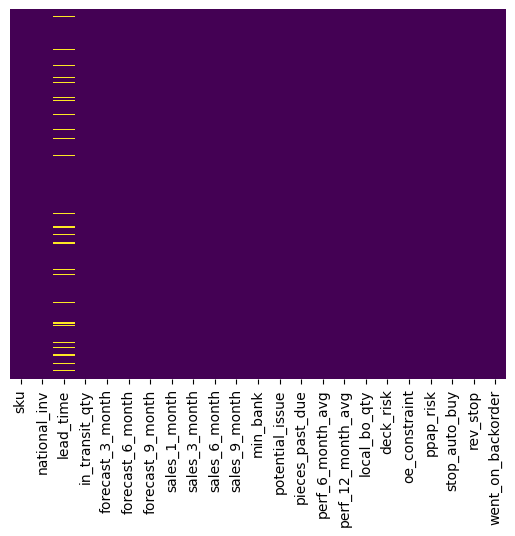

In [9]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
train.isnull().sum()

sku                     0
national_inv            0
lead_time            5168
in_transit_qty          1
forecast_3_month        1
forecast_6_month        1
forecast_9_month        1
sales_1_month           1
sales_3_month           1
sales_6_month           1
sales_9_month           1
min_bank                1
potential_issue         1
pieces_past_due         1
perf_6_month_avg        1
perf_12_month_avg       1
local_bo_qty            1
deck_risk               1
oe_constraint           1
ppap_risk               1
stop_auto_buy           1
rev_stop                1
went_on_backorder       1
dtype: int64

In [11]:
train.drop(['sku'], axis=1, inplace=True)

<Axes: xlabel='went_on_backorder', ylabel='count'>

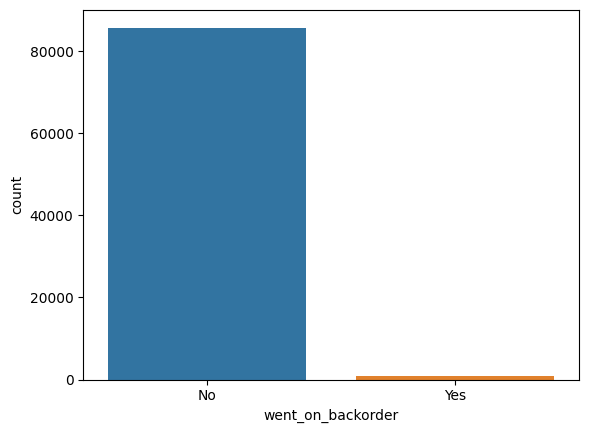

In [12]:
sns.countplot(x="went_on_backorder", data=train )

In [13]:
train[['deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop', 
              'potential_issue']]=train[['deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop', 
              'potential_issue']].replace({'Yes':1, 'No':0})

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86604 entries, 0 to 86603
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national_inv       86604 non-null  int64  
 1   lead_time          81436 non-null  float64
 2   in_transit_qty     86603 non-null  float64
 3   forecast_3_month   86603 non-null  float64
 4   forecast_6_month   86603 non-null  float64
 5   forecast_9_month   86603 non-null  float64
 6   sales_1_month      86603 non-null  float64
 7   sales_3_month      86603 non-null  float64
 8   sales_6_month      86603 non-null  float64
 9   sales_9_month      86603 non-null  float64
 10  min_bank           86603 non-null  float64
 11  potential_issue    86603 non-null  float64
 12  pieces_past_due    86603 non-null  float64
 13  perf_6_month_avg   86603 non-null  float64
 14  perf_12_month_avg  86603 non-null  float64
 15  local_bo_qty       86603 non-null  float64
 16  deck_risk          866

In [15]:
x = train.drop(['went_on_backorder'], axis =1)
y = train['went_on_backorder']

In [16]:
#creating the pipeline for the imputation and scaling for numerical features
from sklearn.pipeline import Pipeline

num_preprocessor = Pipeline(
    steps = [('imputation_mean', SimpleImputer(missing_values = np.nan, strategy='mean')),
            ('robust_scaler', RobustScaler()),
            ])

In [17]:
#creating the pipeline for categorical features
cat_preprocessor = Pipeline(
    steps=[
        ('imputation_constant', SimpleImputer(strategy='most_frequent'))
        
    ]
)

In [18]:
preprocessor = ColumnTransformer(
    [
        
        ('categorical', cat_preprocessor,['rev_stop', 'stop_auto_buy', 
                                       'ppap_risk', 'oe_constraint', 'deck_risk', 'potential_issue']),
        
        ('numerical', num_preprocessor, ['national_inv', 'in_transit_qty', 'lead_time', 'forecast_3_month', 
                                          'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 
                                          'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 
                                          'perf_12_month_avg', 'perf_12_month_avg', 'local_bo_qty'])
        
        
    ]
)

In [19]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [20]:
#creating the function to calculate the cost of the model

def total_cost(y_true, y_pred):
    '''
    This function takes y_true, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [21]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

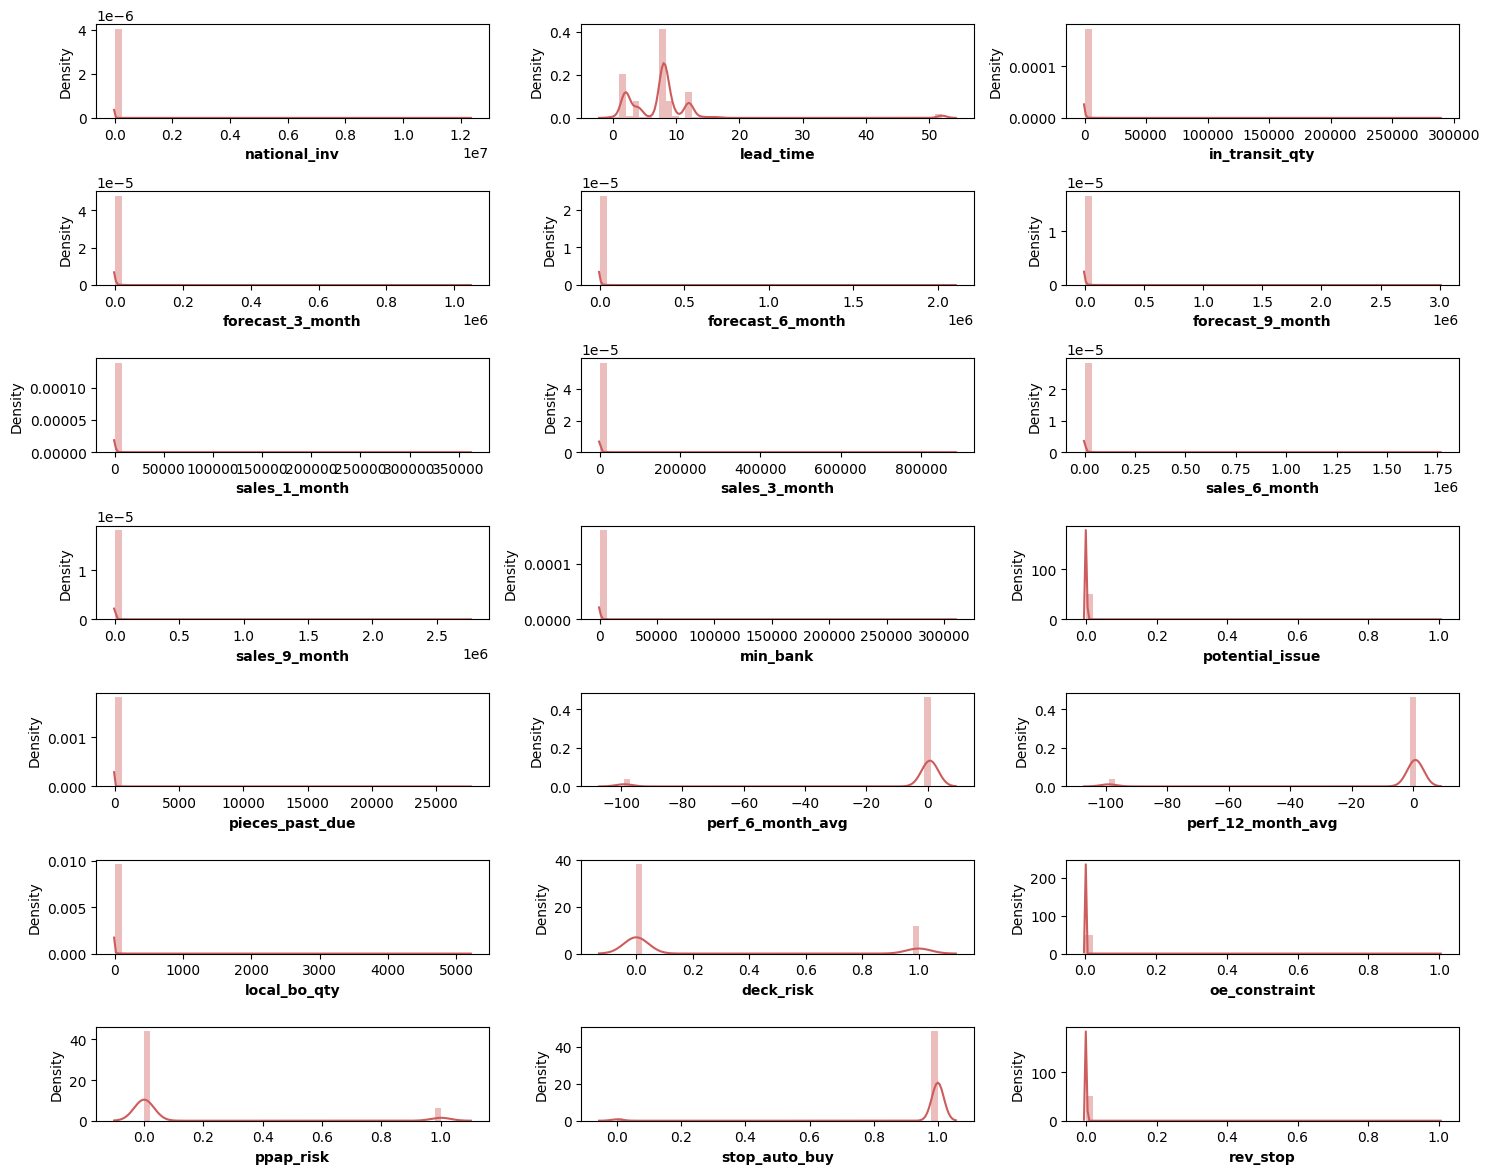

In [22]:
numeric_features = [feature for feature in train.columns if train[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=train[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [23]:
y=y.replace({'Yes':1, 'No':0})

In [24]:
y.value_counts()

0.0    85724
1.0      879
Name: went_on_backorder, dtype: int64

In [25]:
y.fillna(method='ffill', inplace=True)

In [26]:
X_preprocessed = preprocessor.fit_transform(x)

In [27]:
from imblearn.combine import SMOTETomek

In [28]:
y.shape

(86604,)

In [29]:
x.shape

(86604, 21)

In [30]:
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
X_res, y_res = smt.fit_resample(X_preprocessed, y)

In [31]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [32]:
report = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9997
- F1 score: 0.9997
- Precision: 0.9998
- Recall: 0.9997
- Roc Auc Score: 0.9997
- COST: 11170.
----------------------------------
Model performance for Test set
- Accuracy: 0.9930
- F1 score: 0.9930
- Precision: 0.9906
- Recall: 0.9955
- Roc Auc Score: 0.9929
- COST: 40140.


Decision Tree
Model performance for Training set
- Accuracy: 0.9997
- F1 score: 0.9997
- Precision: 0.9998
- Recall: 0.9997
- Roc Auc Score: 0.9997
- COST: 11660.
----------------------------------
Model performance for Test set
- Accuracy: 0.9861
- F1 score: 0.9862
- Precision: 0.9821
- Recall: 0.9904
- Roc Auc Score: 0.9860
- COST: 86120.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9462
- F1 score: 0.9467
- Precision: 0.9360
- Recall: 0.9577
- Roc Auc Score: 0.9463
- COST: 1491300.
----------------------------------
Model performance for Test set
- Accuracy: 0.9460
- F1 score: 0.9470
- Precision: 0.9366
- Recall: 0.9576


In [33]:
report

,Model Name,Cost
4,K-Neighbors Classifier,29750
0,Random Forest,40140
5,XGBClassifier,62630
6,CatBoosting Classifier,64740
1,Decision Tree,86120
2,Gradient Boosting,377200
7,AdaBoost Classifier,735600
3,Logistic Regression,1287220


In [34]:
final_model = KNeighborsClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_preprocessed, y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [36]:
print("Final KNeighbors Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final KNeighbors Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final KNeighbors Classifier Accuracy Score (Train) : 0.9745411054308906
Final KNeighbors Classifier Accuracy Score (Test) : 0.964674309384207


In [37]:
print("Final KNeighbors Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final KNeighbors Classifier Cost Metric(Test) : 29750


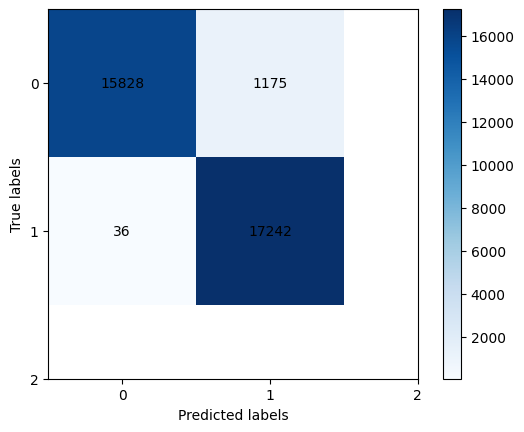

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1, 2])
plt.yticks([0, 1, 2])
plt.colorbar()

# Add counts to the heatmap
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, confusion[i, j], ha="center", va="center")

plt.show()